In [56]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = "cpu"

In [57]:
neg_rng, pos_rng = -0.3, 0.3
t_min, t_max = -0.6, 0.6
neg_obs, pos_obs = -0.9, 0.9
a_min, a_max = 0.5, 10
n_samples = 11
n_disp = 420
snr_dB = 40
t_rng = torch.linspace(neg_obs, pos_obs, n_samples).to(device)
t_rng_disp = torch.linspace(neg_obs, pos_obs, n_disp).to(device)
scale = 5

In [58]:
class FRIModel(nn.Module):
    def __init__(self, n_inp, n_out, neg_rng, pos_rng, scale):
        super(FRIModel, self).__init__()

        self.n_inp = n_inp
        self.n_brd = scale * n_inp
        self.neg_rng = neg_rng
        self.pos_rng = pos_rng

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * n_inp, 128)
        self.fc2 = nn.Linear(128, n_out)
        self.brd_pts = torch.linspace(neg_rng, pos_rng, scale * n_inp).to(device)

        ## Gaussian
        self.g1 = torch.exp(-(self.brd_pts**2)/( (2 * (0.18 ** 2))))
        self.g2 = torch.exp(-(self.brd_pts**2)/( (2 * (0.09 ** 2))))

        ## Gaussian pair
        # self.gp = 1.4*(torch.exp(-(self.brd_pts + 0.2)**2 / (2 * (0.045 ** 2))) + torch.exp(-(self.brd_pts - 0.19)**2 / (2 * (0.045 ** 2))))
        # self.gp = 1.25 * torch.exp(-(self.brd_pts + 0.1)**2 / (2 * (0.06 ** 2))) + 0.7 * torch.exp(-(self.brd_pts - 0.16)**2 / (2 * (0.07 ** 2)))

        ## Learnable Kernel
        self.coeffs = nn.Parameter(torch.exp(-(self.brd_pts**2)/(2 * (self.pos_rng ** 2))))

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.gelu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_ker(self):
        return self.coeffs
    
    def get_g1(self):
        return self.g1
    
    def get_g2(self):
        return self.g2
    
    def get_gp(self):
        return self.gp

    def get_brd_pts(self):
        return self.brd_pts


    def fn_val(self, c1, c2, strt, t_val, sep):

        ret_val = (c1 + ((c2 - c1) * (t_val - strt)) / sep).sum(dim=1)
        return ret_val


    def get_spikes(self, aks, tks):
        ker = self.get_ker().unsqueeze(0).unsqueeze(1)
        a = aks.unsqueeze(2) * ker
        t = tks.unsqueeze(2) + self.brd_pts

        return a, t

    def get_sig(self, t_samps, a, t):

        diffs = torch.abs(t.unsqueeze(-1) - t_samps.unsqueeze(0).unsqueeze(0).unsqueeze(0).expand(t.shape[0], t.shape[1], t.shape[2], -1))
        min_ids = torch.argmin(diffs, dim=-2)

        t_fs = torch.gather(t, 2, min_ids)
        t_samps_exp = t_samps.unsqueeze(0).unsqueeze(0).expand(t_fs.shape[0], t_fs.shape[1], -1)

        cond_1 = (t_fs < t_samps_exp) & (diffs[:, :, self.n_brd // 2, :] < self.pos_rng)
        cond_2 = (t_fs >= t_samps_exp) & (diffs[:, :, self.n_brd // 2, :] < self.pos_rng)
        cond_3 = (min_ids == 0)
        cond_4 = (min_ids == self.n_brd - 1)

        min_ids[cond_3] = 1
        min_ids[cond_4] = self.n_brd - 2

        strt_pts = torch.where(cond_3 | cond_4, -1, torch.where(cond_1, torch.gather(t, 2, min_ids), torch.gather(t, 2, min_ids - 1)))
        c1_vals = torch.where(cond_3 | cond_4, 0, torch.where(cond_1, torch.gather(a, 2, min_ids), torch.gather(a, 2, min_ids - 1)))
        c2_vals = torch.where(cond_3 | cond_4, 0, torch.where(cond_2, torch.gather(a, 2, min_ids - 1), torch.gather(a, 2, min_ids)))

        return self.fn_val(c1_vals, c2_vals, strt_pts, t_samps, self.brd_pts[1] - self.brd_pts[0])

    def get_signal(self, aks, tks, t_rng):
        a_, t_ = self.get_spikes(aks, tks)
        sig = self.get_sig(t_rng, a_, t_)
        return sig

In [59]:
model = FRIModel(n_samples, 3, neg_rng, pos_rng, scale).to(device)
model.load_state_dict(torch.load("l1_loss/kernel_locs3_samples11_40dB.pt", map_location=device, weights_only=True))
model.eval()

FRIModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

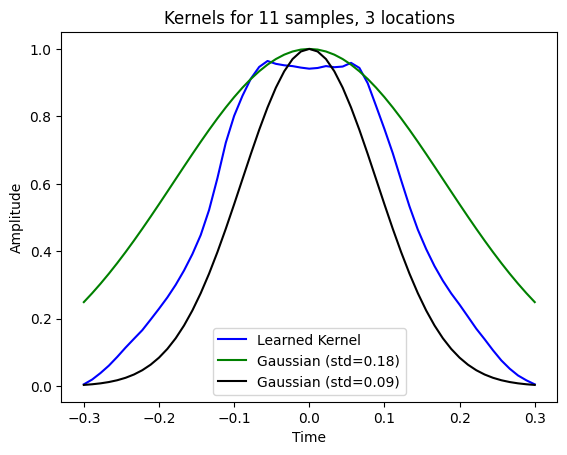

In [60]:
y_k = model.get_ker().detach().cpu().numpy()
y_g1 = model.get_g1().detach().cpu().numpy()
y_g2 = model.get_g2().detach().cpu().numpy()
# y_gp = model.get_gp().detach().cpu().numpy()
x = model.get_brd_pts().detach().cpu().numpy()
plt.plot(x, y_k, label="Learned Kernel", color="b")
plt.plot(x, y_g1, label="Gaussian (std=0.18)", color="g")
plt.plot(x, y_g2, label="Gaussian (std=0.09)", color="k")
# plt.plot(x, y_gp, label="Gaussian Pair", color="r")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Kernels for 11 samples, 3 locations")
plt.savefig("kernels_locs3_samples11.png")
# plt.plot()